In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange,tqdm
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
from diffusion_simulation import diffusion_simulation
from network import network

In [182]:
def print_metrics(sim_id, is_no0):
    params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
          'noise_dist': 'logistic', 'noise_dist_param': 1,
          'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
          'is_network_given':True, 'network_dir':f'../instances/{sim_id}/edge.csv',  
          'is_value_given':True, 'value_dir':f'../instances/{sim_id}/v.csv'
         }
    G = network(params)
    
    df = pd.read_csv(f'../instances/{sim_id}/results.csv')

    if is_no0:
        is_not_0 = G.in_degree > 0
    
        if G.n<len(df):
            df = df[:G.n]
        df_1 = df[is_not_0]
        mape = np.mean(np.abs(df_1['sim']-df_1['fp'])/df_1['sim'])
        
        G.cal_mean_inv_indeg()
        pd.DataFrame({'n':[G.n], 'd_mean':[np.mean(G.in_degree)], 'inv_ind_density':[np.mean(1/G.in_degree[is_not_0])], 
                      'mape':[mape]}
                    ).to_csv(f'../instances/{sim_id}/metrics_no0.csv', index=None)
    else:
        mape = np.mean(np.abs(df['sim']-df['fp'])/df['sim'])
        
        G.cal_mean_inv_indeg()
        pd.DataFrame({'n':[G.n], 'd_min':[np.min(G.in_degree_adj)], 'd_max':[np.max(G.in_degree)], 
                     'd_mean':[np.mean(G.in_degree)], 'out_in_ratio': [np.max(G.out_degree)/max(np.min(G.in_degree),1)], 
                     'deg_corr':[np.corrcoef(G.in_degree, G.out_degree)[0,1]],
                     'inv_ind_density':[G.ave_inv_indeg], 
                      'mape':[mape]}
                    ).to_csv(f'../instances/{sim_id}/metrics.csv', index=None)

## __Figure 3__: Performance of ER graph (with varying network size)

In [89]:
dict_density = {'1_n13': lambda n:1/n**1.3,
                '1_n11': lambda n:1/n**1.1,
                '1_n': lambda n:1/n, 
                'sqrtlogn_n': lambda n:np.sqrt(np.log(n))/n,
                'logn_n': lambda n:np.log(n)/n, 
                'logn2_n': lambda n:np.log(n)**2/n,
                '1': lambda n: 0.1}

In [ ]:
l_n = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000] # Network size
l_pn = ['1_n11', '1_n', 'logn2_n', '1'] # Network density

### Generate one instance for each ER graph parameter pair

In [91]:
rep = 1 # For illustration purposes, generate one repetition. To fully replicate the result in the paper, change this to 50.

for pn in l_pn:
    for n in l_n:
        for i in range(1,rep+1):
            sim_id = f'ER_{pn}/n{n}_{i}'
            os.makedirs(f'../instances/{sim_id}', exist_ok=True)
            params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                      'noise_dist': 'logistic', 'noise_dist_param':1,
                      'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
                      'network_type': 'ER',
                      'is_network_given':False, 'network_size': n, 'ER_prob':dict_density[pn](n), 'network_dir':'',
                      'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4, 'value_dir':''
                     }
            
            G = network(params)
            sample = diffusion_simulation(G,params)
            sample.start_diffusion()
            sample.run_fixed_point()
            sample.output()

Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.
Instance generated with 1000 nodes.
Instance generated with 2000 nodes.
Instance generated with 5000 nodes.
Instance generated with 10000 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.
Instance generated with 1000 nodes.
Instance generated with 2000 nodes.
Instance generated with 5000 nodes.
Instance generated with 10000 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.
Instance generated with 1000 nodes.
Instance generated with 2000 nodes.
Instance generated with 5000 nodes.
Instance generated with 10000 nodes.
Instance generated with 20 nodes.
Instance gen

### Calculate the statistics

In [ ]:
for pn in l_pn:
    for n in l_n:
        for i in range(1,rep+1):
            print_metrics(f'ER_{pn}/n{n}_{i}', True)
            print_metrics(f'ER_{pn}/n{n}_{i}', False)

In [92]:
dict_results = dict()

for pn in l_pn:
    rec_mape, rec_inv_deg, rec_mean_inv = [], [], []
    for n in l_n:
        mape, inv_deg, mean_inv  = [], [], []
        for cnt in range(1,rep+1):
            df = pd.read_csv(f'../instances/ER_{pn}/n{n}_{cnt}/metrics_no0.csv')
            mape.append(df['mape'].values[0]*100)
            inv_deg.append(df['inv_ind_density'].values[0])
            mean_inv.append(1/df['d_mean'].values[0])
        rec_mape.append(mape)
        rec_inv_deg.append(inv_deg)
        rec_mean_inv.append(mean_inv)

    dict_results[(pn,'mape')] = rec_mape
    dict_results[(pn,'inv_deg')] = rec_inv_deg
    dict_results[(pn,'mean_inv')] = rec_mean_inv
    

Instance generated with 18 nodes.
Instance generated with 18 nodes.
Instance generated with 50 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.
Instance generated with 500 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 2000 nodes.
Instance generated with 2000 nodes.
Instance generated with 5000 nodes.
Instance generated with 5000 nodes.
Instance generated with 9997 nodes.
Instance generated with 9997 nodes.
Instance generated with 19 nodes.
Instance generated with 19 nodes.
Instance generated with 50 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.
Instance generated with 500 nodes.
Instance generated w

### Replicate Figure 3

(0.0, 35.0)

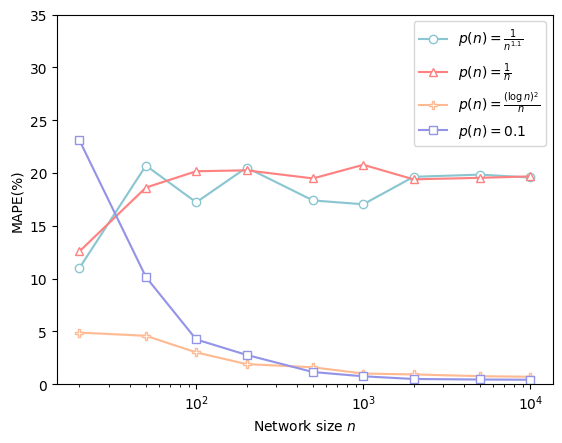

In [93]:
# size
plt.plot(l_n, np.mean(dict_results[('1_n11','mape')],axis=1), c='#8ac6d1', marker='o', markerfacecolor='white', label='$p(n)=\\frac{1}{n^{1.1}}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n11','mape')],0.05,axis=1), np.quantile(dict_results[('1_n11','mape')],0.95,axis=1), color='#8ac6d1', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1_n','mape')],axis=1), c='#ff8080', marker='^', markerfacecolor='white', label='$p(n)=\\frac{1}{n}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n','mape')],0.05,axis=1), np.quantile(dict_results[('1_n','mape')],0.95,axis=1), color='#ff8080', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('logn2_n','mape')],axis=1), c='#ffba92', marker='P', markerfacecolor='white', label='$p(n)=\\frac{(\\log n)^2}{n}$')
plt.fill_between(l_n, np.quantile(results[('logn2_n','mape')],0.05,axis=1), np.quantile(results[('logn2_n','mape')],0.95,axis=1), color='#ffba92', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1','mape')],axis=1), c='#9394e7', marker='s', markerfacecolor='white', label='$p(n)=0.1$')
plt.fill_between(l_n, np.quantile(dict_results[('1','mape')],0.05,axis=1), np.quantile(dict_results[('1','mape')],0.95,axis=1), color='#9394e7', alpha=0.1)
plt.xscale("log")
plt.legend()
plt.xlabel('Network size $n$')
plt.ylabel('MAPE(%)')
plt.ylim(0,35)

(-0.01, 1.0)

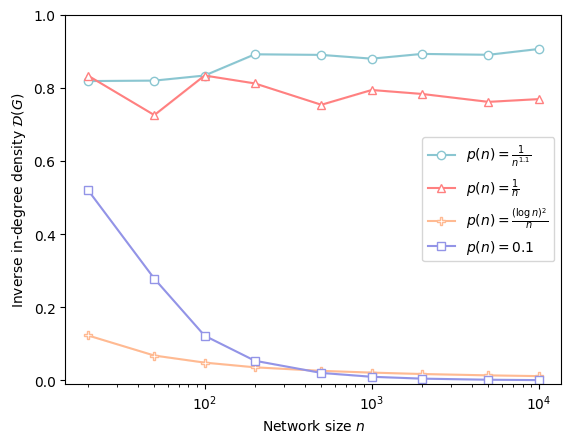

In [94]:
# size
plt.plot(l_n, np.mean(dict_results[('1_n11','inv_deg')],axis=1), c='#8ac6d1', marker='o', markerfacecolor='white', label='$p(n)=\\frac{1}{n^{1.1}}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n11','inv_deg')],0.05,axis=1), np.quantile(dict_results[('1_n11','inv_deg')],0.95,axis=1), color='#8ac6d1', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1_n','inv_deg')],axis=1), c='#ff8080', marker='^', markerfacecolor='white', label='$p(n)=\\frac{1}{n}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n','inv_deg')],0.05,axis=1), np.quantile(dict_results[('1_n','inv_deg')],0.95,axis=1), color='#ff8080', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('logn2_n','inv_deg')],axis=1), c='#ffba92', marker='P', markerfacecolor='white', label='$p(n)=\\frac{(\\log n)^2}{n}$')
plt.fill_between(l_n, np.quantile(dict_results[('logn2_n','inv_deg')],0.05,axis=1), np.quantile(dict_results[('logn2_n','inv_deg')],0.95,axis=1), color='#ffba92', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1','inv_deg')],axis=1), c='#9394e7', marker='s', markerfacecolor='white', label='$p(n)=0.1$')
plt.fill_between(l_n, np.quantile(dict_results[('1','inv_deg')],0.05,axis=1), np.quantile(dict_results[('1','inv_deg')],0.95,axis=1), color='#9394e7', alpha=0.1)
plt.xscale("log")
plt.legend()
plt.xlabel('Network size $n$')
plt.ylabel('Inverse in-degree density $\mathcal{D}(G)$')
plt.ylim(-0.01,1)

Text(0, 0.5, 'Inverse of mean in-degree')

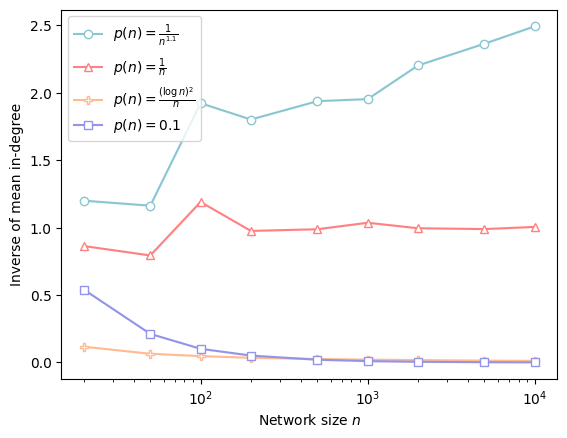

In [95]:
# size
plt.plot(l_n, np.mean(dict_results[('1_n11','mean_inv')],axis=1), c='#8ac6d1', marker='o', markerfacecolor='white', label='$p(n)=\\frac{1}{n^{1.1}}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n11','mean_inv')],0.05,axis=1), np.quantile(dict_results[('1_n11','mean_inv')],0.95,axis=1), color='#8ac6d1', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1_n','mean_inv')],axis=1), c='#ff8080', marker='^', markerfacecolor='white', label='$p(n)=\\frac{1}{n}$')
plt.fill_between(l_n, np.quantile(dict_results[('1_n','mean_inv')],0.05,axis=1), np.quantile(dict_results[('1_n','mean_inv')],0.95,axis=1), color='#ff8080', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('logn2_n','mean_inv')],axis=1), c='#ffba92', marker='P', markerfacecolor='white', label='$p(n)=\\frac{(\\log n)^2}{n}$')
plt.fill_between(l_n, np.quantile(dict_results[('logn2_n','mean_inv')],0.05,axis=1), np.quantile(dict_results[('logn2_n','mean_inv')],0.95,axis=1), color='#ffba92', alpha=0.1)
plt.plot(l_n, np.mean(dict_results[('1','mean_inv')],axis=1), c='#9394e7', marker='s', markerfacecolor='white', label='$p(n)=0.1$')
plt.fill_between(l_n, np.quantile(dict_results[('1','mean_inv')],0.05,axis=1), np.quantile(dict_results[('1','mean_inv')],0.95,axis=1), color='#9394e7', alpha=0.1)
plt.xscale("log")
plt.legend()
plt.xlabel('Network size $n$')
plt.ylabel('Inverse of mean in-degree')

## __Figure 4__: Performance of ER graph (with varying network density) 

### Generate one instance for each __additional__ ER graph parameter pair

In [97]:
l_pn = ['1_n13', 'sqrtlogn_n', 'logn_n'] # Network density
l_n = [1000] # Network size

rep = 1 # For illustration purposes, generate one repetition. To fully replicate the result in the paper, change this to 50.

for n in l_n:
    for pn in l_pn:
        for i in range(1,rep+1):
            sim_id = f'ER_{pn}/n{n}_{i}'
            os.makedirs(f'../instances/{sim_id}', exist_ok=True)
            params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                      'noise_dist': 'logistic', 'noise_dist_param':1,
                      'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
                      'network_type': 'ER',
                      'is_network_given':False, 'network_size': n, 'ER_prob':dict_density[pn](n), 'network_dir':'',
                      'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4, 'value_dir':''
                     }
            
            G = network(params)
            sample = diffusion_simulation(G,params)
            sample.start_diffusion()
            sample.run_fixed_point()
            sample.output()


Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.


### Calculate the statistics

In [131]:
l_pn = ['1_n13', '1_n11', '1_n', 'sqrtlogn_n', 'logn_n', 'logn2_n', '1']
n = 1000
rep = 1

In [133]:
for pn in l_pn:
    for i in range(1,rep+1):
        print_metrics(f'ER_{pn}/n{n}_{i}', True)
        print_metrics(f'ER_{pn}/n{n}_{i}', False)    

Instance generated with 998 nodes.
Instance generated with 998 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.
Instance generated with 1000 nodes.


In [137]:
dict_results = dict()

rec_mape, rec_inv_deg, rec_mean_inv = [], [], []
for pn in l_pn:
    mape, inv_deg, mean_inv  = [], [], []
    for cnt in range(1,rep+1):
        df = pd.read_csv(f'../instances/ER_{pn}/n{n}_{cnt}/metrics_no0.csv')
        mape.append(df['mape'].values[0]*100)
        inv_deg.append(df['inv_ind_density'].values[0])
        mean_inv.append(1/df['d_mean'].values[0])
    rec_mape.append(mape)
    rec_inv_deg.append(inv_deg)
    rec_mean_inv.append(mean_inv)

dict_results[(n,'mape')] = rec_mape
dict_results[(n,'inv_deg')] = rec_inv_deg
dict_results[(n,'mean_inv')] = rec_mean_inv
    

### Replicate Figure 4

([<matplotlib.axis.XTick at 0x2592f36f890>,
 [Text(1, 0, '$\\frac{1}{n^{1.3}}$'),
  Text(2, 0, '$\\frac{1}{n^{1.1}}$'),
  Text(3, 0, '$\\frac{1}{n}$'),
  Text(4, 0, '$\\frac{\\sqrt{\\log{n}}}{n}$'),
  Text(5, 0, '$\\frac{\\log{n}}{n}$'),
  Text(6, 0, '$\\frac{(\\log{n})^2}{n}$'),
  Text(7, 0, '$0.1$')])

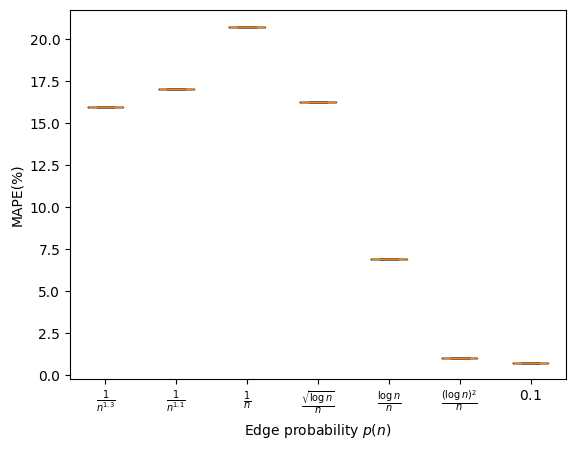

In [141]:
plt.boxplot(dict_results[(n,'mape')])
plt.xlabel('Edge probability $p(n)$')
plt.ylabel('MAPE(%)')
plt.xticks([1,2,3,4,5,6,7],['$\\frac{1}{n^{1.3}}$', '$\\frac{1}{n^{1.1}}$', '$\\frac{1}{n}$', '$\\frac{\\sqrt{\\log{n}}}{n}$', '$\\frac{\\log{n}}{n}$','$\\frac{(\\log{n})^2}{n}$', '$0.1$'])

([<matplotlib.axis.XTick at 0x2593749b920>,
 [Text(1, 0, '$\\frac{1}{n^{1.3}}$'),
  Text(2, 0, '$\\frac{1}{n^{1.1}}$'),
  Text(3, 0, '$\\frac{1}{n}$'),
  Text(4, 0, '$\\frac{\\sqrt{\\log{n}}}{n}$'),
  Text(5, 0, '$\\frac{\\log{n}}{n}$'),
  Text(6, 0, '$\\frac{(\\log{n})^2}{n}$'),
  Text(7, 0, '$0.1$')])

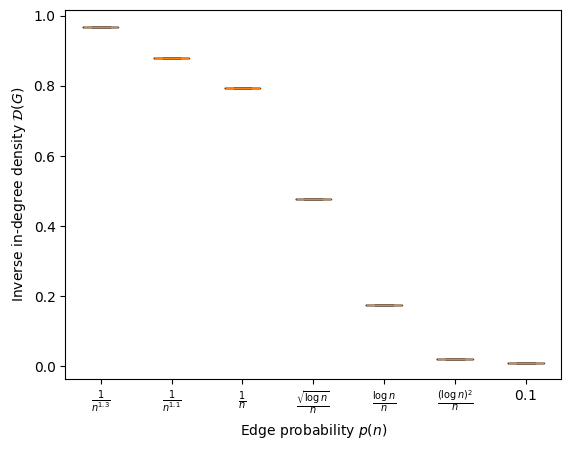

In [143]:
plt.boxplot(dict_results[(n,'inv_deg')])
plt.xlabel('Edge probability $p(n)$')
plt.ylabel('Inverse in-degree density $\mathcal{D}(G)$')
plt.xticks([1,2,3,4,5,6,7],['$\\frac{1}{n^{1.3}}$', '$\\frac{1}{n^{1.1}}$', '$\\frac{1}{n}$', '$\\frac{\\sqrt{\\log{n}}}{n}$', '$\\frac{\\log{n}}{n}$','$\\frac{(\\log{n})^2}{n}$', '$0.1$'])

([<matplotlib.axis.XTick at 0x25937473920>,
 [Text(1, 0, '$\\frac{1}{n^{1.3}}$'),
  Text(2, 0, '$\\frac{1}{n^{1.1}}$'),
  Text(3, 0, '$\\frac{1}{n}$'),
  Text(4, 0, '$\\frac{\\sqrt{\\log{n}}}{n}$'),
  Text(5, 0, '$\\frac{\\log{n}}{n}$'),
  Text(6, 0, '$\\frac{(\\log{n})^2}{n}$'),
  Text(7, 0, '$0.1$')])

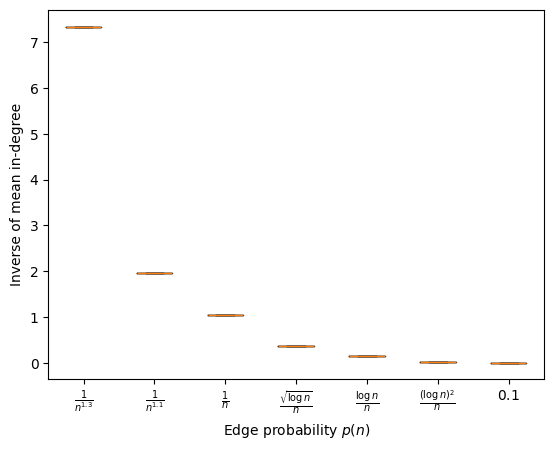

In [145]:
plt.boxplot(dict_results[(n,'mean_inv')])
plt.xlabel('Edge probability $p(n)$')
plt.ylabel('Inverse of mean in-degree')
plt.xticks([1,2,3,4,5,6,7],['$\\frac{1}{n^{1.3}}$', '$\\frac{1}{n^{1.1}}$', '$\\frac{1}{n}$', '$\\frac{\\sqrt{\\log{n}}}{n}$', '$\\frac{\\log{n}}{n}$','$\\frac{(\\log{n})^2}{n}$', '$0.1$'])

## __Table 1__: Efficiency of ER Graph

### Generate one instance for each ER graph parameter pair __with trajectory__

In [ ]:
l_n = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000] 
pn = '1'

rep = 1 # For illustration, generate one repetition. To fully replicate the result in the paper, change this to 50.


In [107]:
for n in l_n:
    for i in range(1,rep+1):
        sim_id = f'ER_{pn}_keep_traj/n{n}_{i}'
        os.makedirs(f'../instances/{sim_id}', exist_ok=True)
        params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                  'noise_dist': 'logistic', 'noise_dist_param':1,
                  'cnt_iter': 100000, 't_warmup':1000, 'is_traj':True, 
                  'network_type': 'ER',
                  'is_network_given':False, 'network_size': n, 'ER_prob':0.1, 'network_dir':'',
                  'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4, 'value_dir':''
                 }
        
        G = network(params)
        sample = diffusion_simulation(G,params)
        sample.start_diffusion()
        sample.run_fixed_point()
        sample.output()

Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 500 nodes.


### Compute the efficiency

In [147]:
for n in l_n:
    print('Network size:', n)
    
    sim_id = f'ER_1_keep_traj/n{n}_1'
    df_traj = pd.read_csv(f'../instances/{sim_id}/results_traj.csv')
    df = pd.read_csv(f'../instances/{sim_id}/results.csv')
    mape = np.mean(np.abs(df['sim']-df['fp'])/df['sim'])
    t = pd.read_csv(f'../instances/{sim_id}/t.csv')['fp'][0]
    print('FPA time:', t)
    
    is_p = False
    
    for t in range(200):
        t1 = t*500+1
        if (np.mean(np.abs(df['sim']-df_traj[f'p_{t1}'])/df['sim']) < mape) and not is_p:
            print('A-ABS time:', df_traj[f't_{t1}'][0])
            is_p = True
        if np.mean(np.abs(df['sim']-df_traj[f'sim_{t1}'])/df['sim']) < mape:
            print('Naive ABS time:', df_traj[f't_{t1}'][0])
            break
    print('=======================================================')

Network size: 20
FPA time 0.0
A-ABS time 0.0580096244812011
Naive ABS time 0.0580096244812011
Network size: 50
FPA time 0.0020003318786621
A-ABS time 0.1035926342010498
Naive ABS time 0.1035926342010498
Network size: 100
FPA time 0.0050070285797119
A-ABS time 0.1899938583374023
Naive ABS time 0.3819952011108398
Network size: 200
FPA time 0.0079288482666015
A-ABS time 0.3589990139007568
Naive ABS time 0.7177376747131348
Network size: 500
FPA time 0.0219998359680175
A-ABS time 0.903364896774292
Naive ABS time 9.31708574295044


## __Table 2__: Real-world network

### Construct real-world network edge information

In [149]:
l_real = ['caltech', 'reed', 'haverford', 'simmons', 'amherst']
dict_real = {'caltech': 'Caltech36', 
             'reed': 'Reed98', 
             'haverford': 'Haverford76', 
             'simmons': 'Simmons81', 
             'amherst': 'Amherst41'}

In [151]:
for real in l_real:
    network_name = dict_real[real]
    os.makedirs(f'../instances/{real}', exist_ok=True)
    df = pd.read_csv(f'../instances/{network_name}.txt',sep=' ', names=['from_edge', 'to_edge'])
    df_1 = df.copy()
    df_1['from_edge'], df_1['to_edge'] = df['to_edge'], df['from_edge']
    # build a undirected graph
    pd.concat([df,df_1], ignore_index=True).to_csv(f'../instances/{real}/edge.csv', index=None)

### Generate one instance for each real-world network

In [155]:
rep = 1 # For illustration, generate one repetition. To fully replicate the result in the paper, change this to 50.

for real in l_real:
    for i in range(1,rep+1):
        sim_id = f'{real}/sim_{i}'
        os.makedirs(f'../instances/{sim_id}', exist_ok=True)
        params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                  'noise_dist': 'logistic', 'noise_dist_param':1,
                  'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
                  'is_network_given':True, 'network_dir':f'../instances/{real}/edge.csv',
                  'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4
                 }
        
        G = network(params)
        sample = diffusion_simulation(G,params)
        sample.start_diffusion()
        sample.run_fixed_point()
        sample.output()

Instance generated with 770 nodes.
Instance generated with 963 nodes.
Instance generated with 1447 nodes.
Instance generated with 1519 nodes.
Instance generated with 2236 nodes.


### Calculate the statistics

In [158]:
for real in l_real:
    for i in range(1,rep+1):
        print_metrics(f'{real}/sim_{i}', False)    

Instance generated with 770 nodes.
Instance generated with 963 nodes.
Instance generated with 1447 nodes.
Instance generated with 1519 nodes.
Instance generated with 2236 nodes.


In [176]:
for real in l_real:
    print('Real-worl network:', real)
    for i in range(1,rep+1):
        sim_id = f'{real}/sim_{i}'
        df = pd.read_csv(f'../instances/{sim_id}/metrics.csv')
        print(df)
        
    print('=======================================================')

Real-worl network: caltech
     n  d_min  d_max     d_mean  out_in_ratio  deg_corr  inv_ind_density  \
0  770    0.0  248.0  43.262337         248.0       1.0          0.11078   

       mape  
0  0.032366  
Real-worl network: reed
     n  d_min  d_max     d_mean  out_in_ratio  deg_corr  inv_ind_density  \
0  963    0.0  313.0  39.069572         313.0       1.0         0.096206   

       mape  
0  0.030304  
Real-worl network: haverford
      n  d_min  d_max    d_mean  out_in_ratio  deg_corr  inv_ind_density  \
0  1447    0.0  375.0  82.36213         375.0       1.0         0.042673   

       mape  
0  0.015113  
Real-worl network: simmons
      n  d_min  d_max     d_mean  out_in_ratio  deg_corr  inv_ind_density  \
0  1519    0.0  300.0  43.433838         300.0       1.0         0.085736   

       mape  
0  0.027343  
Real-worl network: amherst
      n  d_min  d_max   d_mean  out_in_ratio  deg_corr  inv_ind_density  \
0  2236    0.0  467.0  81.3542         467.0       1.0         0.

### Compute the efficiency

In [180]:
for real in l_real:
    for i in range(1,rep+1):
        sim_id = f'{real}_keep_traj/sim_{i}'
        os.makedirs(f'../instances/{sim_id}', exist_ok=True)
        params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                  'noise_dist': 'logistic', 'noise_dist_param':1,
                  'cnt_iter': 100000, 't_warmup':1000, 'is_traj':True, 
                  'network_type': 'ER',
                  'is_network_given':True, 'network_dir':f'../instances/{real}/edge.csv',
                  'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4
                 }
        
        G = network(params)
        sample = diffusion_simulation(G,params)
        sample.start_diffusion()
        sample.run_fixed_point()
        sample.output()

Instance generated with 770 nodes.
Instance generated with 963 nodes.
Instance generated with 1447 nodes.
Instance generated with 1519 nodes.
Instance generated with 2236 nodes.


In [190]:
for real in l_real:
    print('Network:', real)
    
    sim_id = f'{real}_keep_traj/sim_{i}'
    df_traj = pd.read_csv(f'../instances/{sim_id}/results_traj.csv')
    df = pd.read_csv(f'../instances/{sim_id}/results.csv')
    mape = np.mean(np.abs(df['sim']-df['fp'])/df['sim'])
    t = pd.read_csv(f'../instances/{sim_id}/t.csv')['fp'][0]
    print('FPA time:', t)
    
    is_p = False
    
    for t in range(200):
        t1 = t*500+1
        if (np.mean(np.abs(df['sim']-df_traj[f'p_{t1}'])/df['sim']) < mape) and not is_p:
            print('A-ABS time:', df_traj[f't_{t1}'][0])
            is_p = True
        if np.mean(np.abs(df['sim']-df_traj[f'sim_{t1}'])/df['sim']) < mape:
            print('Naive ABS time:', df_traj[f't_{t1}'][0])
            break
    print('=======================================================')

Network: caltech
FPA time: 0.0319936275482177
A-ABS time: 1.3667237758636477
Naive ABS time: 2.2824084758758545
Network: reed
FPA time: 0.0419914722442626
A-ABS time: 1.6587672233581543
Naive ABS time: 3.323836088180542
Network: haverford
FPA time: 0.0657389163970947
A-ABS time: 2.621974468231201
Naive ABS time: 13.928982019424438
Network: simmons
FPA time: 0.115640640258789
A-ABS time: 2.688887119293213
Naive ABS time: 6.275633811950684
Network: amherst
FPA time: 0.1009998321533203
A-ABS time: 4.028524875640869
Naive ABS time: 20.10701465606689


## __Figure 5__: FPA performance vs $\mathcal{D}(G)$

### Generate one instance for each power-law graph parameter pair

In [214]:
dict_alpha = {'25': 2.5,
              '30': 3,
              '35': 3.5}

In [227]:
l_alpha = ['25', '30', '35']
theta = '0'
l_n = [20,50,100,200,500,1000,2000,5000,10000]
rep = 1 # For illustration purposes, generate one repetition. To fully replicate the result in the paper, change this to 50.

In [230]:
for alpha in l_alpha:
    for n in l_n:
        for i in range(1,rep+1):
            sim_id = f'PL_alpha{alpha}_theta{theta}/n{n}_{i}'
            os.makedirs(f'../instances/{sim_id}', exist_ok=True)
            params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                      'noise_dist': 'logistic', 'noise_dist_param':1,
                      'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
                      'network_type': 'PL',
                      'is_network_given':False, 'network_size': n, 'PL_exponent':dict_alpha[alpha], 'PL_corr':0, 'PL_xmin':2, 'network_dir':'',
                      'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4, 'value_dir':''
                     }
            
            G = network(params)
            sample = diffusion_simulation(G,params)
            sample.start_diffusion()
            sample.run_fixed_point()
            sample.output()

Instance generated with 2000 nodes.
Instance generated with 2000 nodes.
Instance generated with 2000 nodes.


In [212]:
dict_theta = {'neg10': -1,
              'neg05': -0.5,
              'pos05': 0.5,
              'pos10':1}

In [216]:
alpha = '25'
l_theta = ['neg05', 'pos05', 'neg10', 'pos10']
l_n = [20,50,100,200,500,1000,2000,5000,10000]
rep = 1 # For illustration purposes, generate one repetition. To fully replicate the result in the paper, change this to 50.

In [218]:
for theta in l_theta:
    for n in l_n:
        for i in range(1,rep+1):
            sim_id = f'PL_alpha{alpha}_theta{theta}/n{n}_{i}'
            os.makedirs(f'../instances/{sim_id}', exist_ok=True)
            params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
                      'noise_dist': 'logistic', 'noise_dist_param':1,
                      'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
                      'network_type': 'PL',
                      'is_network_given':False, 'network_size': n, 'PL_exponent':2.5, 'PL_corr':dict_theta[theta], 'PL_xmin':2, 'network_dir':'',
                      'is_value_given':False, 'v_dist':'uniform_neg', 'v_dist_param': 4, 'value_dir':''
                     }
            
            G = network(params)
            sample = diffusion_simulation(G,params)
            sample.start_diffusion()
            sample.run_fixed_point()
            sample.output()

Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.


### Calculate the statistics

In [238]:
for alpha in l_alpha:
    for n in l_n:
        for i in range(1,rep+1):
            print_metrics(f'PL_alpha{alpha}_theta0/n{n}_{i}', False)
for theta in l_theta:
    for n in l_n:
        for i in range(1,rep+1):
            print_metrics(f'PL_alpha25_theta{theta}/n{n}_{i}', False)

Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.
Instance generated with 20 nodes.
Instance generated with 50 nodes.
Instance generated with 100 nodes.
Instance generated with 200 nodes.


In [241]:
dict_results = dict()

l_real = ['caltech', 'reed', 'haverford', 'simmons', 'amherst']

rec_mape, rec_inv_deg = [], []
for network in l_real:
    mape, inv_deg  = [], []
    for i in range(1,rep+1):
        df = pd.read_csv(f'../instances/{network}/sim_{i}/metrics.csv')
        mape.append(df['mape'].values[0]*100)
        inv_deg.append(df['inv_ind_density'].values[0])
    rec_mape.append(mape)
    rec_inv_deg.append(inv_deg)

dict_results[('real','mape')] = rec_mape
dict_results[('real','inv_deg')] = rec_inv_deg
    

In [243]:
l_pn = ['1_n11', '1_n', 'logn2_n', '1']
l_n = [20,50,100,200,500,1000,2000,5000,10000]

for pn in l_pn:
    rec_mape, rec_inv_deg = [], []
    for n in l_n:
        mape, inv_deg  = [], []
        for i in range(1,rep+1):
            df = pd.read_csv(f'../instances/ER_{p}/n{n}_{i}/metrics.csv')
            mape.append(df['mape'].values[0]*100)
            inv_deg.append(df['inv_ind_density'].values[0])
        rec_mape.append(mape)
        rec_inv_deg.append(inv_deg)

    dict_results[(pn,'mape')] = rec_mape
    dict_results[(pn,'inv_deg')] = rec_inv_deg
    

In [255]:
l_pn = ['1_n13', 'sqrtlogn_n', 'logn_n', '1']
l_n = [1000]

for n in l_n:
    rec_mape, rec_inv_deg = [], []
    for pn in l_pn:
        mape, inv_deg  = [], []
        for i in range(1,rep+1):
            df = pd.read_csv(f'../instances/ER_{p}/n{n}_{i}/metrics.csv')
            mape.append(df['mape'].values[0]*100)
            inv_deg.append(df['inv_ind_density'].values[0])
        rec_mape.append(mape)
        rec_inv_deg.append(inv_deg)

    dict_results[(n,'mape')] = rec_mape
    dict_results[(n,'inv_deg')] = rec_inv_deg
    

In [247]:
l_alpha = ['25', '30', '35']
theta = '0'
l_n = [20,50,100,200,500,1000,2000,5000,10000]

for alpha in l_alpha:
    rec_mape, rec_inv_deg = [], []
    for n in l_n:
        mape, inv_deg  = [], []
        for i in range(1,rep+1):
            df = pd.read_csv(f'../instances/PL_alpha{alpha}_theta{theta}/n{n}_{i}/metrics.csv')
            mape.append(df['mape'].values[0]*100)
            inv_deg.append(df['inv_ind_density'].values[0])
        rec_mape.append(mape)
        rec_inv_deg.append(inv_deg)

    dict_results[(alpha,'mape')] = rec_mape
    dict_results[(alpha,'inv_deg')] = rec_inv_deg
    

In [249]:
alpha = '25'
l_theta = ['neg05', 'pos05', 'neg10', 'pos10']
l_n = [20,50,100,200,500,1000,2000,5000,10000]

for theta in l_theta:
    rec_mape, rec_inv_deg = [], []
    for n in l_n:
        mape, inv_deg  = [], []
        for i in range(1,rep+1):
            df = pd.read_csv(f'../instances/PL_alpha{alpha}_theta{theta}/n{n}_{i}/metrics.csv')
            mape.append(df['mape'].values[0]*100)
            inv_deg.append(df['inv_ind_density'].values[0])
        rec_mape.append(mape)
        rec_inv_deg.append(inv_deg)

    dict_results[(theta,'mape')] = rec_mape
    dict_results[(theta,'inv_deg')] = rec_inv_deg
    

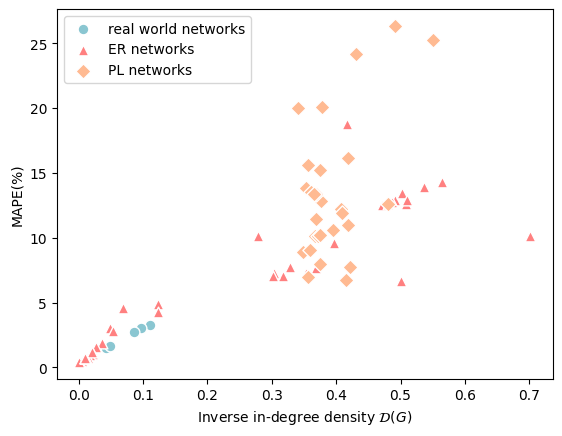

In [257]:
plt.scatter(np.mean(dict_results[('real','inv_deg')],axis=1), np.mean(dict_results[('real','mape')],axis=1), c='#8ac6d1', marker='o', edgecolor='white', s=60, label='real world networks')
plt.scatter(np.mean(dict_results[('1_n11','inv_deg')],axis=1), np.mean(dict_results[('1_n11','mape')],axis=1), c='#ff8080', marker='^', edgecolor='white', s=60, label='ER networks')
plt.scatter(np.mean(dict_results[('1_n','inv_deg')],axis=1), np.mean(dict_results[('1_n','mape')],axis=1), c='#ff8080', marker='^', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('logn2_n','inv_deg')],axis=1), np.mean(dict_results[('logn2_n','mape')],axis=1), c='#ff8080', marker='^', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('1','inv_deg')],axis=1), np.mean(dict_results[('1','mape')],axis=1), c='#ff8080', marker='^', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[(1000,'inv_deg')],axis=1), np.mean(dict_results[(1000,'mape')],axis=1), c='#ff8080', marker='^', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('25','inv_deg')],axis=1), np.mean(dict_results[('25','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60, label='PL networks')
plt.scatter(np.mean(dict_results[('30','inv_deg')],axis=1), np.mean(dict_results[('30','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('35','inv_deg')],axis=1), np.mean(dict_results[('35','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('neg05','inv_deg')],axis=1), np.mean(dict_results[('neg05','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('pos05','inv_deg')],axis=1), np.mean(dict_results[('pos05','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('neg10','inv_deg')],axis=1), np.mean(dict_results[('neg10','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)
plt.scatter(np.mean(dict_results[('pos10','inv_deg')],axis=1), np.mean(dict_results[('pos10','mape')],axis=1), c='#ffba92', marker='D', edgecolor='white', s=60)

plt.xlabel('Inverse in-degree density $\\mathcal{D}(G)$')
plt.ylabel('MAPE(%)')
plt.legend()

## __Figure 6__: Mixture Scheme

In [27]:
folder = 'caltech'
rep = 1 # For illustration, generate one repetition. To fully replicate the result in the paper, change this to 50.
for i in range(1,rep+1):
    sim_id = f'{folder}_re_cal_{t_iter}/sim_{i}'
    os.makedirs(f'../instances/{sim_id}', exist_ok=True)
    params = {'sim_id':sim_id, 'alpha':0.1, 'beta':3.5,
              'noise_dist': 'logistic', 'noise_dist_param':1,
              'cnt_iter': 100000, 't_warmup':1000, 'is_traj':False, 
              'is_network_given':True, 'network_dir':f'../instances/{folder}/sim_{i}/edge.csv',
              'is_value_given':True, 'value_dir':f'../instances/{folder}/sim_{i}/v.csv'
             }
    
    G = network(params)
    sample = diffusion_simulation(G,params)
    sample.run_fixed_point()
    sample.re_cal(t_iter = t_iter)
    sample.output()

Instance generated with 770 nodes.


In [43]:
l_real = ['caltech']
l_recal = [1000]
results = dict()

for net in l_real:
    for recal in l_recal:
        rec_mape_re_cal = []
        for d in range(200):
            mape = []
            for i in range(1,rep+1):
                df = pd.read_csv(f'../instances/{net}/sim_{i}/results.csv')
                df_re_cal = pd.read_csv(f'../instances/{net}_re_cal_{recal}/sim_{i}/results.csv')
                if len(df)>len(df_re_cal):
                    df = df[:len(df_re_cal)]
                diff = (np.abs(df['sim']-df['fp'])/df['sim']).values
                diff_re_cal = (np.abs(df['sim']-df_re_cal['p_re'])/df['sim']).values
                not_low_deg = (df_re_cal['in_deg']>d).values
                diff_re_cal[not_low_deg] =  diff[not_low_deg]
                mape.append(np.mean(diff_re_cal)*100)
            rec_mape_re_cal.append(mape)
        results[(net,'mix',recal)] = rec_mape_re_cal

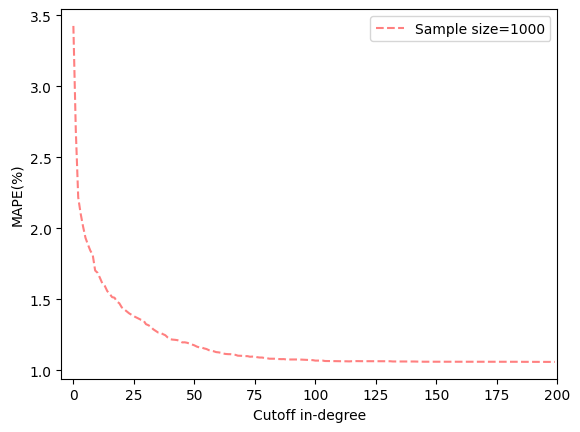

In [49]:
plt.plot(range(200), np.mean(results[('caltech','mix', recal)], axis=1), c='#ff8080', linestyle='--', label = 'Sample size=1000')
plt.xlabel('Cutoff in-degree')
plt.ylabel('MAPE(%)')
plt.xlim(-5,200)
plt.legend()